## Simulation on the fully synthetic classification task

In [ ]:
from mechanism_learn import pipeline as mlpipe
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

syn_data_dir = r"../../../test_data/synthetic_data/"

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16

def linear_decision_boundary(clf, xlim):
    weight = clf.coef_[0]
    bias = clf.intercept_[0]
    k = -weight[0] / weight[1]
    b = -bias / weight[1]
    x = np.linspace(xlim[0], xlim[1], 100)
    decison_boundary = k * x + b
    return decison_boundary

def plot_boundary(ax, X, Y, db, xlim, ylim, plot_title):
    handles = []
    scatter = ax.scatter(x= X[:,0], y = X[:,1], c = Y, s = 10, alpha = 0.4, cmap='coolwarm')
    handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")
    handles += handles_scatter
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    x_ = np.linspace(xlim[0], xlim[1], 100)
    
    true_b = ax.plot([0, 0], [-6, 6], 'k', linewidth=4, label="True boundary")
    confounder = ax.plot([-6,6], [0,0], 'orange', linewidth = 4, label = "Confounder boundary")
    clf_b = ax.plot(x_, db, 'r', linewidth = 4, label= 'Classifier Decision')
    handles += [true_b[0], confounder[0], clf_b[0]]
    ax.set_title(plot_title)
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    return ax, handles

### Load datasets

In [2]:
testcase_dir = r"classification/"
X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv")
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv")
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv")
X_train_conf = np.array(X_train_conf)
Y_train_conf = np.array(Y_train_conf).reshape(-1,1)
Z_train_conf = np.array(Z_train_conf)

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv")
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv")
X_test_unconf = np.array(X_test_unconf)
Y_test_unconf = np.array(Y_test_unconf).reshape(-1,1)

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv")
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv")
X_test_conf = np.array(X_test_conf)
Y_test_conf = np.array(Y_test_conf).reshape(-1,1)

### Train a deconfounded SVM classifier using mechanism learning

In [3]:
ml_gmm_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                    mechanism_data = Z_train_conf, 
                                                    effect_data = X_train_conf, 
                                                    intv_values = np.unique(Y_train_conf), 
                                                    dist_map = None, 
                                                    est_method = "histogram", 
                                                    n_bins = [0, 10]
                                                    )
ml_gmm_pipeline.cwgmm_fit(comp_k = 6,
                          max_iter = 1000, 
                          tol = 1e-7, 
                          init_method = "kmeans++", 
                          cov_type = "full", 
                          cov_reg = 1e-6, 
                          min_variance_value=1e-6, 
                          random_seed=None, 
                          return_model = False,
                          verbose = 2)

deconf_X_gmm, deconf_Y_gmm = ml_gmm_pipeline.cwgmm_resample(n_samples=5000, return_samples = True)

deconf_gmm_clf = ml_gmm_pipeline.deconf_model_fit(ml_model = svm.SVC(kernel = 'linear', C=5))

CW-GMMs fitting:   0%|          | 0/2 [00:00<?, ?model/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

### Train a deconfounded SVM classifier using CB-based deconfounding method

In [4]:
ml_cb_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                   mechanism_data = Z_train_conf, 
                                                   effect_data = X_train_conf, 
                                                   intv_values = np.unique(Y_train_conf), 
                                                   dist_map = None, 
                                                   est_method = "histogram", 
                                                   n_bins = [0, 10]
                                                   )
deconf_X_cb, deconf_Y_cb = ml_cb_pipeline.cb_resample(n_samples = 5000,
                                                      cb_mode = "fast",
                                                      return_samples = True)

deconf_cb_clf = ml_cb_pipeline.deconf_model_fit(ml_model = svm.SVC(kernel = 'linear', C=5))

CB Resampling:   0%|          | 0/2 [00:00<?, ?it/s]

### Train a confounded SVM classifier

In [5]:
conf_clf = svm.SVC(kernel = 'linear', C=5)
conf_clf = conf_clf.fit(X_train_conf, Y_train_conf.reshape(-1))

### Compare thier decision boundaries

In [6]:
decision_boundary_deconf_gmm = linear_decision_boundary(clf = deconf_gmm_clf, xlim = [-4,4])
decision_boundary_deconf_cb = linear_decision_boundary(clf = deconf_cb_clf, xlim = [-4,4])
decision_boundary_conf = linear_decision_boundary(clf = conf_clf, xlim = [-4,4])

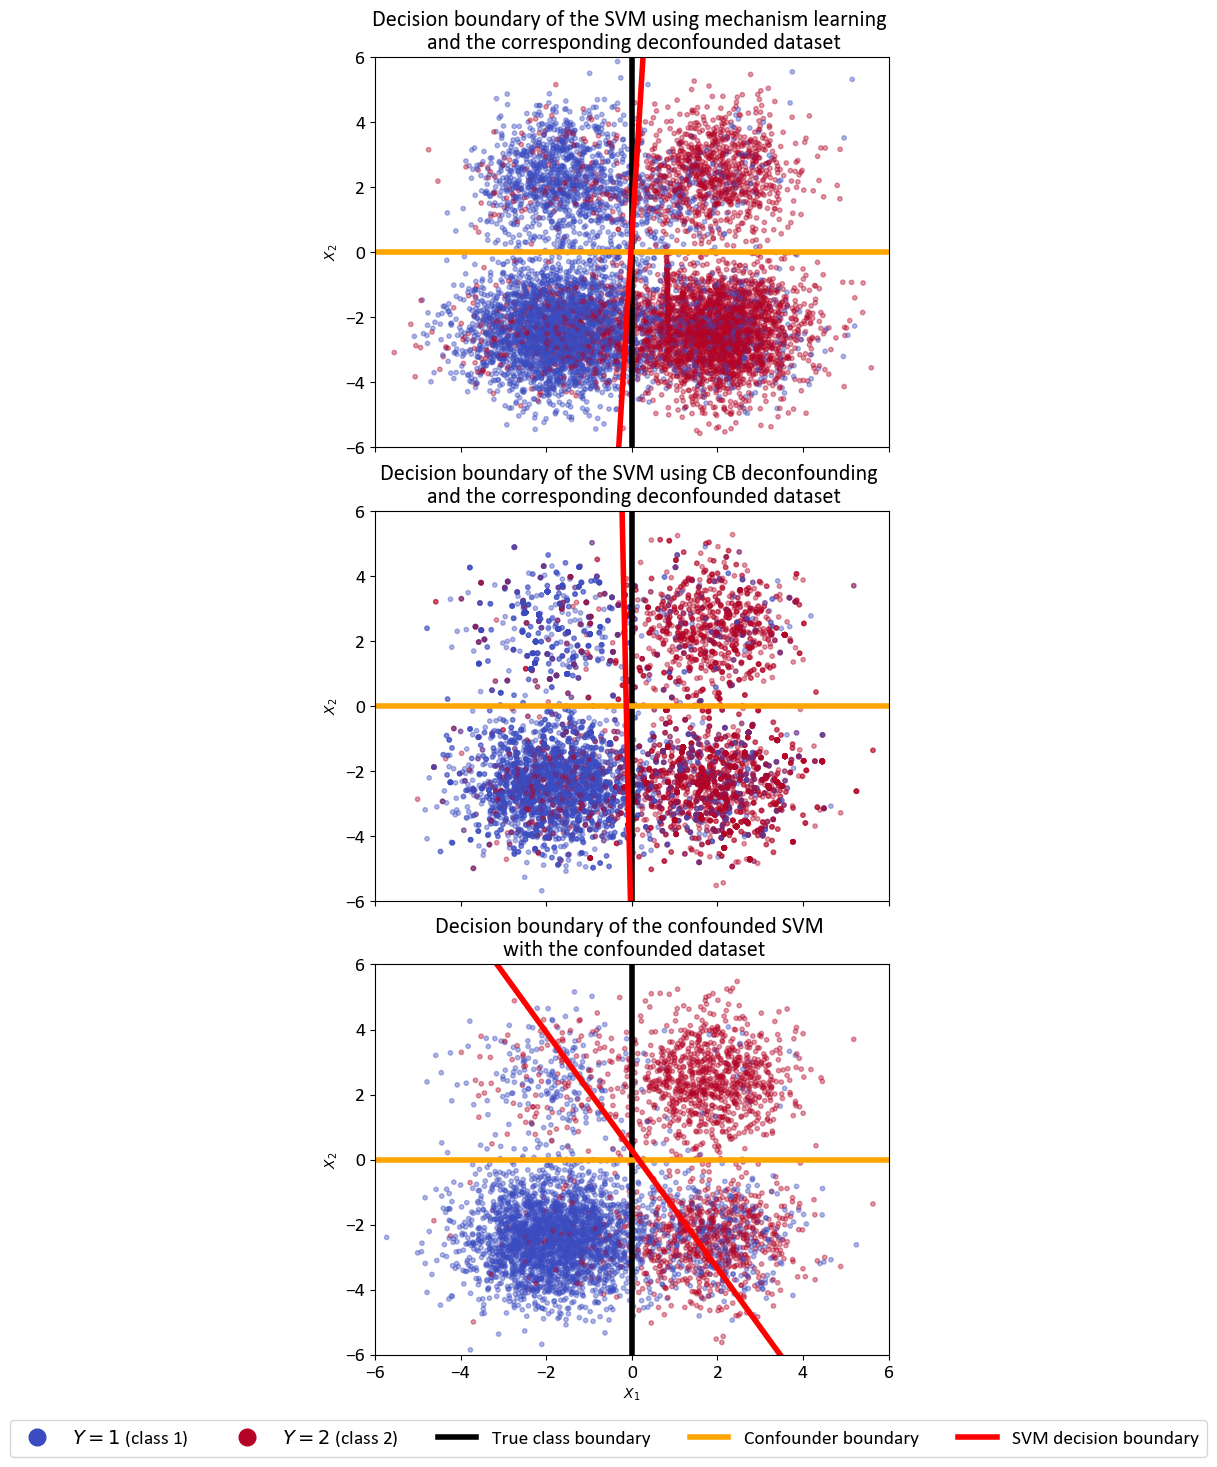

In [7]:
fig, axes = plt.subplots(3,1, figsize = (6,16))
axes[0], _ = plot_boundary(axes[0], deconf_X_gmm, deconf_Y_gmm, 
                        decision_boundary_deconf_gmm, [-6,6], [-6,6], 'Decision boundary of the SVM using mechanism learning \n and the corresponding deconfounded dataset')
axes[1], _ = plot_boundary(axes[1], deconf_X_cb, deconf_Y_cb, 
                        decision_boundary_deconf_cb, [-6,6], [-6,6], 'Decision boundary of the SVM using CB deconfounding \n and the corresponding deconfounded dataset')
axes[2], handles = plot_boundary(axes[2], X_train_conf, Y_train_conf, 
                        decision_boundary_conf, [-6,6], [-6,6], 'Decision boundary of the confounded SVM \n with the confounded dataset')
axes[0].tick_params(labelbottom=False)
axes[0].set_xlabel('')  
axes[1].tick_params(labelbottom=False)
axes[1].set_xlabel('')  
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']
legend =fig.legend(handles=handles,
                   labels=labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=5,
                   markerscale=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


### Compare thier performance on the confounded and non-confounded test datasets

In [9]:
print("Test on the non-confounded test set:")

y_pred_gmm_deconf_unconf = deconf_gmm_clf.predict(X_test_unconf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_unconf, y_pred_gmm_deconf_unconf, digits=4))
print("-"*20)
y_pred_cb_deconf_unconf = deconf_cb_clf.predict(X_test_unconf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_unconf, y_pred_cb_deconf_unconf, digits=4))
print("-"*20)
y_pred_conf_unconf = conf_clf.predict(X_test_unconf)
print("Report of confonded model:")
print(classification_report(Y_test_unconf, y_pred_conf_unconf, digits=4))


print("*"*30)
print("Test on the confounded test set:")

y_pred_gmm_deconf_conf = deconf_gmm_clf.predict(X_test_conf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_conf, y_pred_gmm_deconf_conf, digits=4))
print("-"*20)
y_pred_cb_deconf_conf = deconf_cb_clf.predict(X_test_conf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_conf, y_pred_cb_deconf_conf, digits=4))
print("-"*20)
y_pred_conf_conf = conf_clf.predict(X_test_conf)
print("Report of confonded model:")
print(classification_report(Y_test_conf, y_pred_conf_conf, digits=4))


Test on the non-confounded test set:
Report of deconfounded model using mechanism learning:
              precision    recall  f1-score   support

           1     0.7739    0.8508    0.8105       362
           2     0.9103    0.8589    0.8839       638

    accuracy                         0.8560      1000
   macro avg     0.8421    0.8549    0.8472      1000
weighted avg     0.8609    0.8560    0.8573      1000

--------------------
Report of deconfounded model using CB-based method:
              precision    recall  f1-score   support

           1     0.7681    0.8508    0.8073       362
           2     0.9098    0.8542    0.8812       638

    accuracy                         0.8530      1000
   macro avg     0.8390    0.8525    0.8443      1000
weighted avg     0.8585    0.8530    0.8544      1000

--------------------
Report of confonded model:
              precision    recall  f1-score   support

           1     0.6513    0.8564    0.7399       362
           2     0.9008 